# Supply Chain Optimization Analysis

This dataset is derived from a fashion and beauty startup, focusing on the makeup product supply chain. It consists of 100 rows and 24 columns, capturing production details, supplier information, inventory levels, shipping data, and other relevant metrics.

## Business Questions

Five business questions have been formulated in alignment withvstrategic needs within the supply chain.

- Which product types generate the highest revenue, and how do their defect rates compare?</br>
- Which suppliers have the highest defect rates, and how does this impact costs?</br>
- Which shipping carriers and transportation modes are most cost-effective?</br>
- How do lead times and manufacturing lead times correlate with stock levels and availability?</br>
- Which locations have the highest shipping costs, and why?

## Analysis Plan

The analysis begins with comprehensive data cleaning to ensure high-quality inputs for subsequent examination. Following this, we systematically address the key business questions, presenting insightful summaries and findings aligned with organizational objectives. To drive strategic decision-making, we will provide actionable recommendations supported by data-driven evidence. Finally, we implement a predictive analytics framework featuring two machine learning models designed to forecast supplier performance. This predictive capability enables procurement teams to identify potential risks in advance, facilitating proactive supplier relationship management and operational optimization.

# Supply Chain Optimization Analysis
## Data Cleaning

To ensure data quality, the process involves checking for missing values and duplicates, followed by cleaning headers by removing quotes and spaces. Numeric columns, such as Price and Revenue generated, are converted to float, while integer columns like Stock levels and Order quantities are converted to int. String columns, including Inspection results, are standardized by trimming spaces and adjusting the case. Additionally, the data is validated to identify and address abnormalities, such as unexpected negative values, to maintain accuracy and consistency.

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


# Loading the data
data = pd.read_csv('supply_chain_data.csv')
print(data.head(5))

  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29          

In [8]:
# Cleaning headers: remove quotes and extra spaces
data.columns = [col.strip().replace('"', '') for col in data.columns]

# Checking for missing values and duplicates
missing_values = data.isnull().sum()
duplicates = data.duplicated().sum()

# Converting numeric columns to appropriate types
numeric_columns = ['Price', 'Revenue generated', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping costs', 'Lead time', 
                   'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Defect rates', 'Costs']

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Converting integer columns
integer_columns = ['Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Lead time', 'Production volumes', 'Manufacturing lead time']
for col in integer_columns:
    data[col] = data[col].fillna(0).astype(int)

# Cleaning string columns
string_columns = ['Product type', 'Customer demographics', 'Shipping carriers', 'Supplier name', 'Location', 'Inspection results',
                  'Transportation modes', 'Routes']

for col in string_columns:
    data[col] = data[col].str.strip().str.replace('"', '').str.title()

# Validating data: check for negative values in columns that should be non-negative
non_negative_columns = ['Price', 'Revenue generated', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping costs', 'Lead time',
                        'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Defect rates', 'Costs']

for col in non_negative_columns:
    if (data[col] < 0).any():
        print(f"Warning: Negative values found in {col}")
        data[col] = data[col].clip(lower=0)

# Saving cleaned data for further analysis
cleaned_data = data.copy()

print("Missing values:\n", missing_values)
print("Duplicates:", duplicates)

Missing values:
 Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64
Duplicates: 0
Cleaned data shape: (100, 24)


The dataset consists of 100 rows and 24 columns, with no missing values or duplicates detected. Column headers were cleaned by removing quotes and spaces, and data types were appropriately converted, numeric columns like Price were cast to float, while integer fields such as Stock levels were converted to int. All expected non-negative columns were validated, confirming no negative values. String entries, including product categories like "haircare", were standardized by trimming whitespace and correcting case (e.g., to "Haircare"), ensuring consistency across the dataset.

## Question 1: Revenue and Defect Rates by Product Type

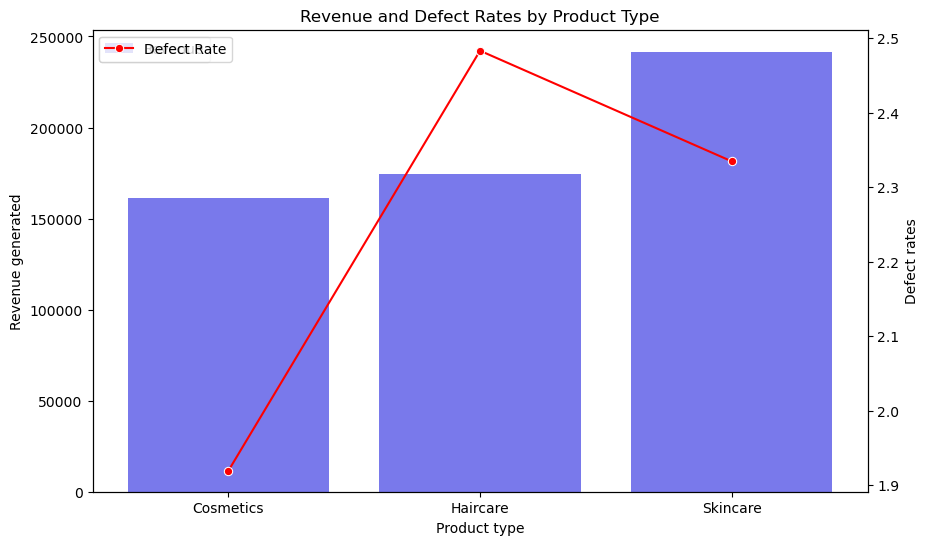

Product Type Summary:
   Product type  Revenue generated  Defect rates  Number of products sold  \
0    Cosmetics      161521.265999      1.919287                    11757   
1     Haircare      174455.390605      2.483150                    13611   
2     Skincare      241628.162133      2.334681                    20731   

   Revenue per unit sold  
0              13.738306  
1              12.817235  
2              11.655403  


In [5]:
product_summary = cleaned_data.groupby('Product type').agg({
    'Revenue generated': 'sum',
    'Defect rates': 'mean',
    'Number of products sold': 'sum'
}).reset_index()
product_summary['Revenue per unit sold'] = product_summary['Revenue generated'] / product_summary['Number of products sold']

# Visualization: Revenue and Defect Rates
plt.figure(figsize=(10, 6))
sns.barplot(x='Product type', y='Revenue generated', data=product_summary, color='blue', alpha=0.6, label='Revenue')
ax2 = plt.twinx()
sns.lineplot(x='Product type', y='Defect rates', data=product_summary, color='red', marker='o', label='Defect Rate')
plt.title('Revenue and Defect Rates by Product Type')
plt.legend(loc='upper left')
plt.show()

print("Product Type Summary:\n", product_summary)

**Summary:** Skincare generates the highest total revenue close to \\$250,000, followed by Haircare and Cosmetics. However, Haircare has the highest average defect rate (2.48%), followed by Skincare (2.33%) and Cosmetics (1.91%).

**Finding:** Skincare’s high revenue is tempered by its high defect rate, suggesting quality issues that could erode profitability. Cosmetics, with the lowest defect rate, may offer a more stable product line.

## Question 2: Defect Rates and Manufacturing Costs by Supplier

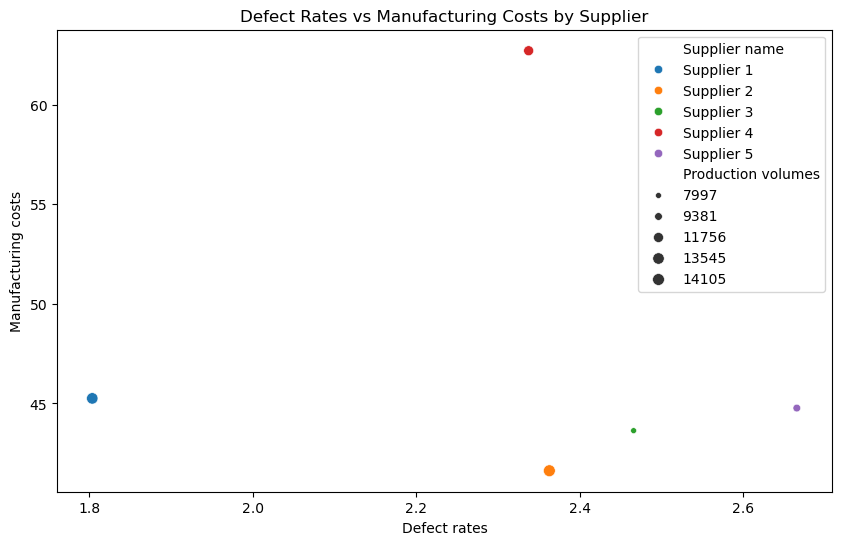


Supplier Summary:
   Supplier name  Defect rates  Manufacturing costs  Production volumes
0    Supplier 1      1.803630            45.254027               13545
1    Supplier 2      2.362750            41.622514               14105
2    Supplier 3      2.465786            43.634121                7997
3    Supplier 4      2.337397            62.709727               11756
4    Supplier 5      2.665408            44.768243                9381


In [19]:
supplier_summary = cleaned_data.groupby('Supplier name').agg({
    'Defect rates': 'mean',
    'Manufacturing costs': 'mean',
    'Production volumes': 'sum'
}).reset_index()

# Visualization: Defect Rates vs Manufacturing Costs
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Defect rates', y='Manufacturing costs', size='Production volumes', hue='Supplier name', data=supplier_summary)
plt.title('Defect Rates vs Manufacturing Costs by Supplier')
plt.show()

print("\nSupplier Summary:\n", supplier_summary)

**Summary:** Supplier 5 has the highest average defect rate (2.66%), followed by Supplier 3 (2.43%). Supplier 1 has the lowest (1.80%). Manufacturing costs are highest for Supplier 4 (\\$62) and lowest for Supplier 2 (\\$41).

**Finding:** Supplier 1 provides the highest reliability with the lowest defect rate, though at a premium cost compared to Suppliers 2 and 3. Supplier 2 delivers the best cost efficiency, combining the lowest manufacturing cost with moderate defect rates and the highest production volume. Supplier 4 is the least cost-effective option due to its steep price of \\$62 per unit and only average defect performance.

## Question 3: Shipping Costs by Carrier and Transportation Mode

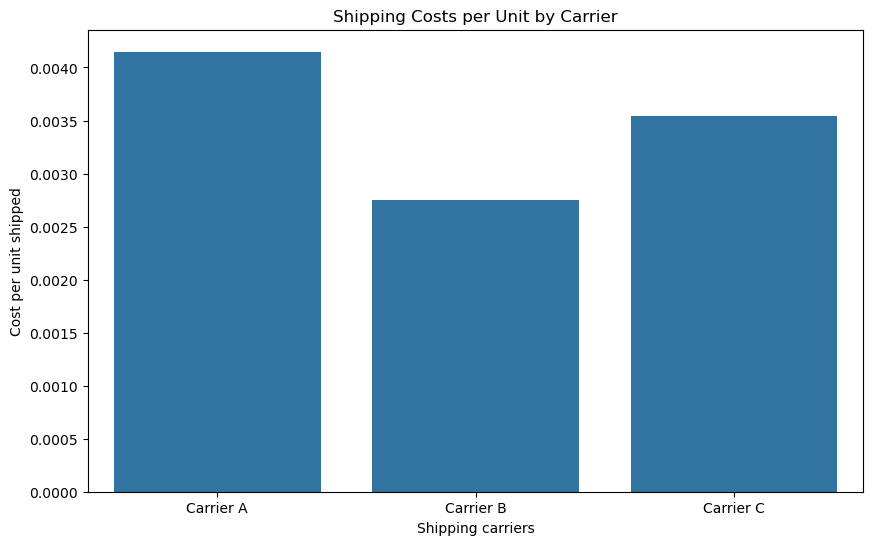

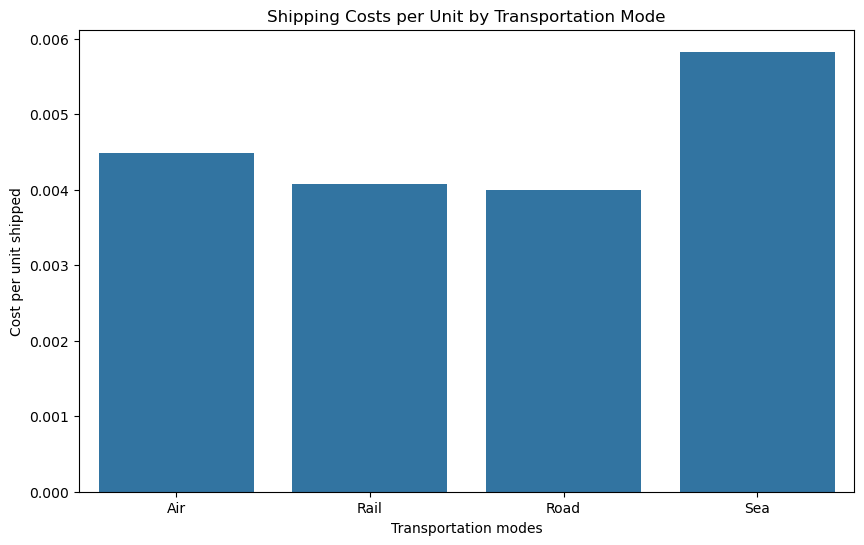


Carrier Summary:
   Shipping carriers  Shipping costs  Order quantities  Cost per unit shipped
0         Carrier A        5.554923              1339               0.004149
1         Carrier B        5.509247              2002               0.002752
2         Carrier C        5.599292              1581               0.003542

Transport Mode Summary:
   Transportation modes  Shipping costs  Order quantities  \
0                  Air        6.017839              1341   
1                 Rail        5.469098              1342   
2                 Road        5.542115              1386   
3                  Sea        4.970294               853   

   Cost per unit shipped  
0               0.004488  
1               0.004075  
2               0.003999  
3               0.005827  


In [34]:
carrier_summary = cleaned_data.groupby('Shipping carriers').agg({
    'Shipping costs': 'mean',
    'Order quantities': 'sum'
}).reset_index()
carrier_summary['Cost per unit shipped'] = carrier_summary['Shipping costs'] / carrier_summary['Order quantities']

transport_summary = cleaned_data.groupby('Transportation modes').agg({
    'Shipping costs': 'mean',
    'Order quantities': 'sum'
}).reset_index()
transport_summary['Cost per unit shipped'] = transport_summary['Shipping costs'] / transport_summary['Order quantities']

# Visualization: Shipping Costs per Unit
plt.figure(figsize=(10, 6))
sns.barplot(x='Shipping carriers', y='Cost per unit shipped', data=carrier_summary)
plt.title('Shipping Costs per Unit by Carrier')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Transportation modes', y='Cost per unit shipped', data=transport_summary)
plt.title('Shipping Costs per Unit by Transportation Mode')
plt.show()

print("\nCarrier Summary:\n", carrier_summary)
print("\nTransport Mode Summary:\n", transport_summary)

**Summary:** Carrier B is the most cost-effective option, delivering the lowest per-unit shipping cost at \\$0.00275 while handling the highest order volume of 2,002 units. Carrier A remains competitive with slightly higher rates, while Carrier C is the most expensive at \\$0.00354 per unit. For shipping modes, sea transport shows the lowest base cost (\\$4.97) but becomes cost-prohibitive on a per-unit basis (\\$0.00583) due to low order volumes. Rail emerges as the optimal mode, offering an excellent balance with a \\$5.47 base cost and competitive $0.00408 per-unit rate. Air shipping is the most expensive option at \\$6.02 base cost and \\$0.00449 per unit, while road transport presents a viable mid-range alternative at \\$0.004 per unit.

**Finding:** Based on the evaluation, Carrier B emerges as the optimal choice, offering the lowest cost per unit while maintaining the highest shipping volume capacity. For transport modes, rail provides the best cost efficiency for bulk shipments. Sea shipping becomes viable only for large batch orders, as its low base cost is offset by high per-unit expenses at lower volumes. Air transport proves to be the least cost-effective option and should be reserved exclusively for time-critical shipments where speed outweighs cost considerations.

## Question 4: Correlation between Lead Times, Stock Levels, and Availability

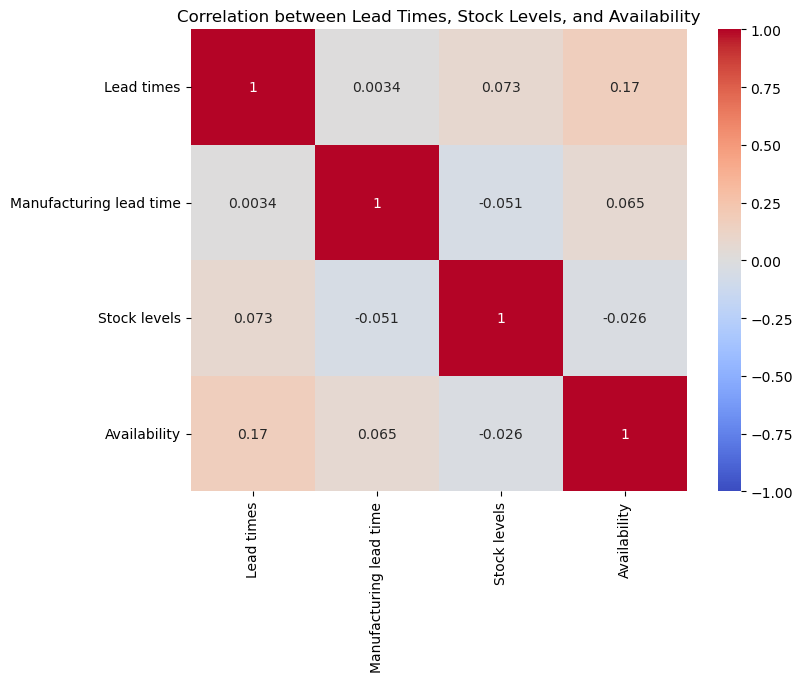

In [39]:
# Question 4: Correlation between Lead Times, Stock Levels, and Availability
correlation_data = cleaned_data[['Lead times', 'Manufacturing lead time', 'Stock levels', 'Availability']]
correlation_matrix = correlation_data.corr()

# Visualization: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Lead Times, Stock Levels, and Availability')
plt.show()

**Summary:** The correlation heatmap shows that there are no strong relationships among lead times, manufacturing lead time, stock levels, and availability. The only slightly notable pattern is a weak positive correlation between lead times and availability (0.17), suggesting that longer lead times may be modestly associated with better product availability. Interestingly, stock levels do not correlate positively with availability, indicating that simply holding more inventory doesn't necessarily improve service levels. Overall, these weak correlations suggest that other factors may be more influential in supply chain performance.

## Question 5: Shipping Costs by Location

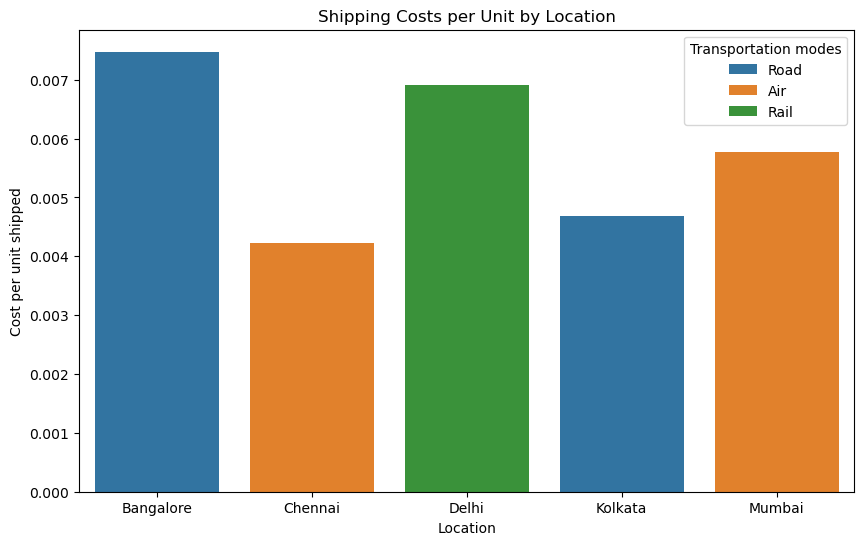


Location Summary:
     Location  Shipping costs  Order quantities Transportation modes  \
0  Bangalore        5.748445               769                 Road   
1    Chennai        4.689079              1109                  Air   
2      Delhi        5.069881               733                 Rail   
3    Kolkata        5.761414              1228                 Road   
4     Mumbai        6.248989              1083                  Air   

   Cost per unit shipped  
0               0.007475  
1               0.004228  
2               0.006917  
3               0.004692  
4               0.005770  


In [43]:
# Question 5: Shipping Costs by Location
location_summary = cleaned_data.groupby('Location').agg({
    'Shipping costs': 'mean',
    'Order quantities': 'sum',
    'Transportation modes': lambda x: x.mode()[0]
}).reset_index()
location_summary['Cost per unit shipped'] = location_summary['Shipping costs'] / location_summary['Order quantities']

# Visualization: Shipping Costs by Location
plt.figure(figsize=(10, 6))
sns.barplot(x='Location', y='Cost per unit shipped', hue='Transportation modes', data=location_summary)
plt.title('Shipping Costs per Unit by Location')
plt.show()


print("\nLocation Summary:\n", location_summary)

**Summary:** Chennai emerges as the most cost-efficient location with a remarkably low per-unit shipping cost of \\$0.00423, achieved through high order volume (1,109 units) that offsets Air transport's typically expensive rates. In contrast, Mumbai's high base cost (\\$6.25) and Bangalore/Delhi's poor per-unit costs (\\$0.00747 and \\$0.00692 respectively) highlight how low order volumes (<800 units) undermine efficiency, regardless of transport mode.

**Finding:** The analysis reveals that order volume significantly impacts cost-effectiveness - high-volume locations like Chennai and Kolkata maintain good per-unit rates even with premium transport modes, while low-volume locations struggle despite moderate base costs. 

## Actionable Recommendations

### Question 1: Revenue and Defect Rates by Product Type
Focus on Skincare as the top revenue generator (\\$241,628) despite its moderate defect rate (2.33%), as its high sales volume (20,731 units) offsets inefficiencies. Haircare has higher defects (2.48%) and lower revenue per unit (\\$12.82), suggesting quality improvements could boost margins. Cosmetics delivers the highest revenue per unit (\\$13.74) and lowest defects (1.92%), making it ideal for premium pricing.

### Question 2: Defect Rates and Manufacturing Costs by
Based on the analysis, Supplier 2 stands out as the best overall choice due to its balanced combination of competitive pricing, reliable volume capacity, and an acceptable defect rate. For organizations prioritizing quality over cost, Supplier 1 remains a strong alternative despite its higher expenses. On the other hand, Supplier 4 and Supplier 5 are less favorable options due to high costs and high defect rates.

### Question 3: Shipping Costs by Carrier and Transportation Mode
For optimal shipping efficiency, it is recommended Carrier B as the primary choice due to its industry-leading cost-per-unit and high volume capacity, with Carrier A serving as a reliable secondary option. Rail transport should be the preferred mode for most shipments, offering the best cost-to-volume ratio. For smaller batch shipments, road transport provides better per-unit economics than sea shipping. While air transport should be reserved for urgent deliveries due to its premium cost, sea shipping only becomes cost-effective for large bulk shipments and should otherwise be avoided for regular operations.

### Question 4: Correlation between Lead Times, Stock Levels, and Availability
The correlation reveals no strong relationships between any of the variables examined. The most notable, though still weak, relationship exists between lead times and product availability. Surprisingly, stock levels and availability show no positive correlation, suggesting potential inefficiencies in inventory management. This disconnect may indicate mismatches between stocked items and actual demand, highlighting opportunities to optimize inventory allocation and reduce excess or obsolete stock.

### Question 5: Shipping Costs by Location
To maximize cost efficiency, prioritize expanding operations in high-volume hubs like Chennai and Kolkata, which offer the best per-unit rates. For Mumbai, negotiate bulk carrier discounts to offset its steep air transport costs. Adjust transport modes strategically which is to reserve air shipping for high-volume routes (e.g., Chennai) where costs are justified. For low-volume locations, optimize Bangalore’s shipments by shifting to rail where possible, and consolidate Delhi orders to boost volume and improve rail cost efficiency.

## Preidctive Modeling for Supplier Performance

This analysis aims to predict if a supplier is High-Risk (1) or Low-Risk (0) based on defect rates and lead times exceeding their respective medians, using XGBoost classifier and Random Forest classifier. The dataset is preprocessed by encoding categorical features (e.g., Inspection results, Supplier name, Location) and scaling numerical features. The model is trained on a split dataset (70% training, 30% testing) and evaluated using a classification report, providing metrics like accuracy, precision, recall, F1-score, and predicted frequency for predicting high-risk suppliers.

### XGBoost Classifier

In [121]:
# Create a risk label (e.g., high-risk if defect rate > median AND lead time > median)
median_lead_time = data['Lead time'].median()
data['Supplier_high_risk'] = ((data['Defect rates'] > median_defect) & (data['Lead time'] > median_lead_time)).astype(int)

# Features for supplier risk
features_supplier = ['Defect rates', 'Lead time', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Supplier name', 'Location']
target_supplier = 'Supplier_high_risk'

# Preprocess data
data_supplier_encoded = pd.get_dummies(data[features_supplier], columns=['Inspection results', 'Supplier name', 'Location'])

# Split data
X_supplier = data_supplier_encoded
y_supplier = data[target_supplier]
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_supplier, y_supplier, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_s_scaled = scaler.fit_transform(X_train_s)
X_test_s_scaled = scaler.transform(X_test_s)

# XGBoost
xgb_supplier = xgb.XGBClassifier(random_state=42)
xgb_supplier.fit(X_train_s_scaled, y_train_s)
y_pred_xgb_s = xgb_supplier.predict(X_test_s_scaled)
print("Supplier Risk (XGBoost):\n", classification_report(y_test_s, y_pred_xgb_s))

# Add predictions back to original data
data['Risk_Prediction'] = risk_predictions

# Identify high-risk suppliers
high_risk_suppliers = data[data['Risk_Prediction'] == 1]['Supplier name'].value_counts()
print("High-Risk Suppliers and their Frequency:")
print(high_risk_suppliers)

Supplier Risk (XGBoost):
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30

High-Risk Suppliers and their Frequency:
Supplier name
Supplier 5    8
Supplier 2    7
Supplier 3    6
Supplier 4    5
Supplier 1    3
Name: count, dtype: int64


### Random Forest Classifier

Supplier Risk (Random Forest):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.95      0.90      0.92        30
weighted avg       0.94      0.93      0.93        30

High-Risk Suppliers and their Frequency:
Supplier name
Supplier 5    8
Supplier 2    7
Supplier 3    6
Supplier 4    5
Supplier 1    3
Name: count, dtype: int64


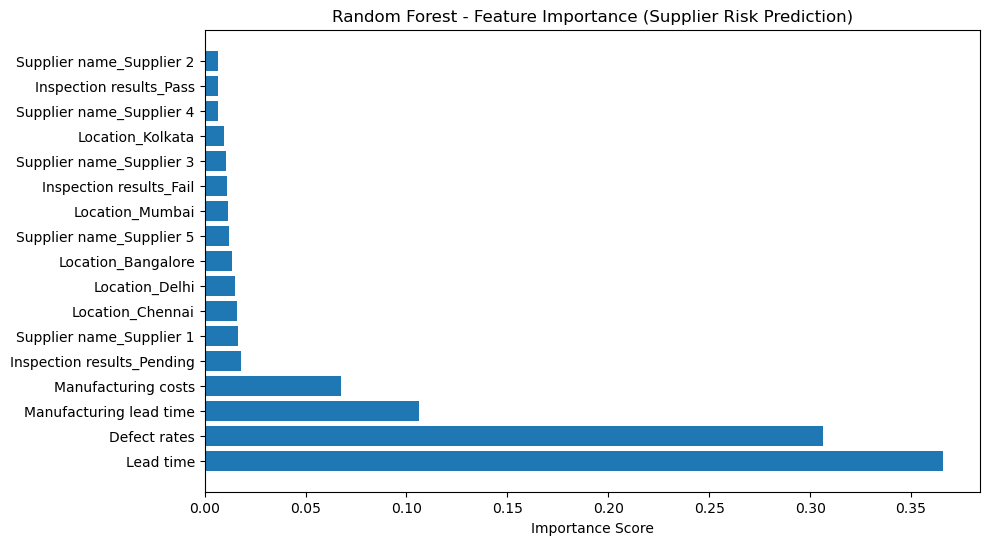

In [117]:
# Random Forest
rf_supplier = RandomForestClassifier(random_state=42)
rf_supplier.fit(X_train_s_scaled, y_train_s)
y_pred_rf_s = rf_supplier.predict(X_test_s_scaled)
print("Supplier Risk (Random Forest):\n", classification_report(y_test_s, y_pred_rf_s))

# Predict on the entire dataset
X_supplier_scaled = scaler.transform(X_supplier)
risk_predictions = rf_supplier.predict(X_supplier_scaled)

# Add predictions back to original data
data['Risk_Prediction'] = risk_predictions

# Identify high-risk suppliers
high_risk_suppliers = data[data['Risk_Prediction'] == 1]['Supplier name'].value_counts()
print("High-Risk Suppliers and their Frequency:")
print(high_risk_suppliers)

# Get feature importances from Random Forest
feature_importances_rf_s = rf_supplier.feature_importances_

# Create a DataFrame for visualization
features_df_rf_s = pd.DataFrame({
    'Feature': X_train_s.columns,
    'Importance': feature_importances_rf_s
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features_df_rf_s['Feature'], features_df_rf_s['Importance'])
plt.title('Random Forest - Feature Importance (Supplier Risk Prediction)')
plt.xlabel('Importance Score')
plt.show()

Both machine learning models demonstrated strong performance, with XGBoost achieving 97% accuracy and Random Forest reaching 93%. The analysis identified Supplier 5 as the highest-risk supplier most frequently, followed by Supplier 2. Feature importance analysis revealed that lead time and defect rates were the most significant predictors in the models' assessments.